In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from EC_Func.metric_plot import plot_confusion_matrix, metric_cal

Using TensorFlow backend.


In [2]:
data, label = make_blobs(n_samples=10000, centers=5, n_features=15, random_state=0)

In [3]:
X_train, X_test, y_train_int, y_test_int = train_test_split(data, label, test_size=0.33, random_state=42)
y_train = to_categorical(y_train_int, 5)
y_test = to_categorical(y_test_int, 5)
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [4]:
import warnings
warnings.filterwarnings('ignore')

def build_model(input_shape = 15):
    model = Sequential()
    model.add(Dense(10, activation = 'relu', kernel_initializer='he_normal', input_shape=(input_shape,)))
    model.add(Dense(8, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(6, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(5, activation = None, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    sgd = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = build_model()
print(model.summary())

print('--------------- fit model -----------------')
model.fit(X_train, y_train,
              batch_size=2048,
              epochs=50,
              validation_data=(X_test, y_test),
              shuffle=True, verbose = 0)

pred = model.predict_classes(X_test)
print(confusion_matrix(np.argmax(y_test, axis = 1), pred))
print(accuracy_score(np.argmax(y_test, axis = 1), pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 35        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None
--------------- fit model -----------------
[[683   0   0   0   0]
 [  0 671   0   0   0]
 [  0   0 661   0   0]
 [  0   0   0 645   0]
 [ 

# Example - select 4 layers

In [5]:
from EC_Func.EC_Classifier_Ball_Tree import EpistemicClassifier
print(X_train.shape)
print(y_train_int.shape, y_train_int)

layer_interest = [0,1,2,3]
EC = EpistemicClassifier(model, layer_interest, metric = 'minkowski', p = 2)
EC.fit(X_train, y_train_int)

(6700, 15)
(6700,) [4 3 0 ... 4 0 3]
Using metric: minkowski
caching hiddens
layer selected: 
dense_1
dense_2
dense_3
dense_4
using Ball Tree for NN Search
building tree for layer 0
building tree for layer 1
building tree for layer 2
building tree for layer 3


# Confusion matrix: I know, I Might Know, I Don't Know

# Predict by number of neighbor

number of neighbor for each layer:  [5, 2, 2, 2]


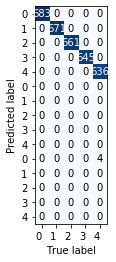

 --------------------------------- 
number of neighbor for each layer:  [10, 4, 4, 4]


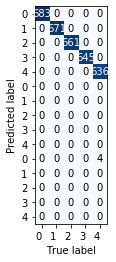

 --------------------------------- 
number of neighbor for each layer:  [15, 6, 6, 6]


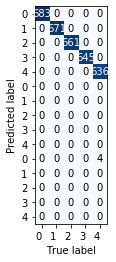

 --------------------------------- 
number of neighbor for each layer:  [20, 8, 8, 8]


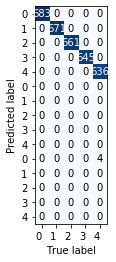

 --------------------------------- 
number of neighbor for each layer:  [25, 10, 10, 10]


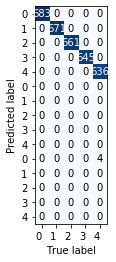

 --------------------------------- 
number of neighbor for each layer:  [30, 12, 12, 12]


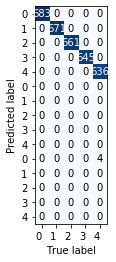

 --------------------------------- 
number of neighbor for each layer:  [35, 14, 14, 14]


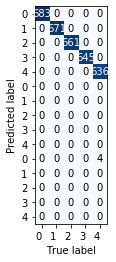

 --------------------------------- 
number of neighbor for each layer:  [40, 16, 16, 16]


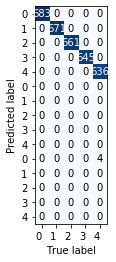

 --------------------------------- 
number of neighbor for each layer:  [45, 18, 18, 18]


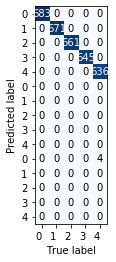

 --------------------------------- 


In [6]:
for i in range(1, 10):
    print('number of neighbor for each layer: ',[5*i, 2*i, 2*i, 2*i])
    pred = EC.predict_class(X_test, n_neigh = [5*i, 4*i, 3*i, 2*i])
    plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))
    print(' --------------------------------- ')

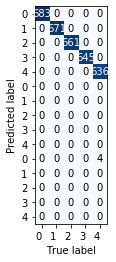

In [7]:
pred = EC.predict_class(X_test, n_neigh = 3)
plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))

# Predict by layer-wise epi distance

Epsilon for each layer: [0.03125, 0.0625, 0.125, 0.25]


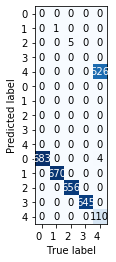

----------------------
Epsilon for each layer: [0.0625, 0.125, 0.25, 0.5]


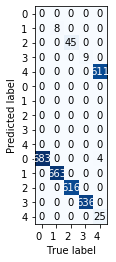

----------------------
Epsilon for each layer: [0.125, 0.25, 0.5, 1.0]


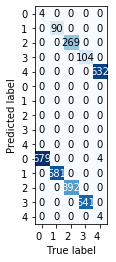

----------------------
Epsilon for each layer: [0.25, 0.5, 1.0, 2.0]


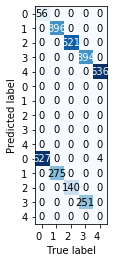

----------------------
Epsilon for each layer: [0.5, 1.0, 2.0, 4.0]


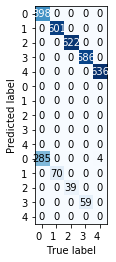

----------------------
Epsilon for each layer: [1, 2, 4, 8]


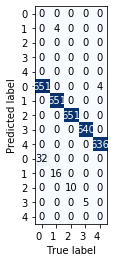

----------------------
Epsilon for each layer: [2, 4, 8, 16]


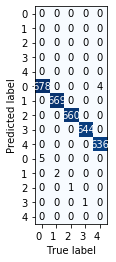

----------------------
Epsilon for each layer: [4, 8, 16, 32]


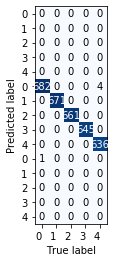

----------------------


In [8]:
for i in range(-5, 3):
    print('Epsilon for each layer:', [2**i, 2*2**i, 4*2**i, 8*2**i])
    pred = EC.predict_class(X_test, dist = [4*2**i, 2*2**i, 1/2*2**i, 1/4*2**i]) # list represent epi in each layer
    plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))
    print('----------------------')

# Adaptive ball without discount

Epsilon ball for input layer: 0.1
adaptive distance in each layer [0.2252673848856973, 0.3596236145688369, 0.6454332136585835, 1.1421833984229606]


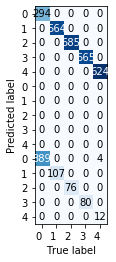

----------------------
Epsilon ball for input layer: 0.2
adaptive distance in each layer [0.4505347697713946, 0.7192472291376738, 1.290866427317167, 2.284366796845921]


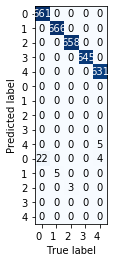

----------------------
Epsilon ball for input layer: 0.30000000000000004
adaptive distance in each layer [0.6758021546570919, 1.0788708437065109, 1.9362996409757507, 3.426550195268882]


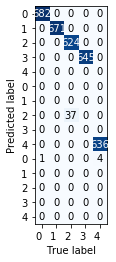

----------------------
Epsilon ball for input layer: 0.4
adaptive distance in each layer [0.9010695395427892, 1.4384944582753476, 2.581732854634334, 4.568733593691842]


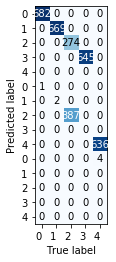

----------------------
Epsilon ball for input layer: 0.5
adaptive distance in each layer [1.1263369244284864, 1.7981180728441843, 3.2271660682929175, 5.710916992114803]


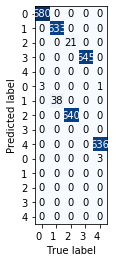

----------------------
Epsilon ball for input layer: 0.6000000000000001
adaptive distance in each layer [1.3516043093141838, 2.1577416874130217, 3.8725992819515014, 6.853100390537764]


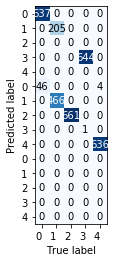

----------------------
Epsilon ball for input layer: 0.7000000000000001
adaptive distance in each layer [1.576871694199881, 2.5173653019818585, 4.518032495610085, 7.995283788960725]


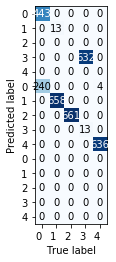

----------------------
Epsilon ball for input layer: 0.8
adaptive distance in each layer [1.8021390790855785, 2.876988916550695, 5.163465709268668, 9.137467187383685]


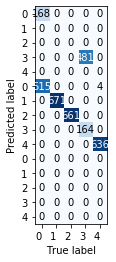

----------------------
Epsilon ball for input layer: 0.9
adaptive distance in each layer [2.0274064639712757, 3.236612531119532, 5.808898922927252, 10.279650585806646]


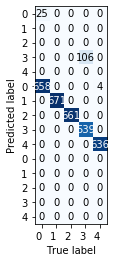

----------------------


In [9]:
for i in range(1, 10):
    print('Epsilon ball for first layer in layer of interest set:', 0.1*i)
    pred = EC.predict_class(X_test, adaptive_ball = True, discount_radius = None, epsilon = 0.1*i) 
    plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))
    print('----------------------')